In [8]:
import cv2 as cv
import glob
import json
import numpy as np
import faiss
import os
import tensorflow as tf
from deepface import DeepFace
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Ensure 'models' and 'data/temp_dir' directories exist
os.makedirs('models', exist_ok=True)
os.makedirs('data/temp_dir', exist_ok=True)

print("Imports successful and directories ensured.")

Imports successful and directories ensured.


In [ ]:
def create_dataset(
                data_dir = "data/facedb/*/*.*",
                json_dir_template = "data/facedb_jsons/{}/{}", # Template for path construction
                ):
    print("Starting create_dataset to generate JSON annotations...")
    image_count = 0
    processed_count = 0
    for img_path in glob.glob(data_dir):
        image_count += 1
        person_objs = []
        img_path_norm = img_path.replace("\\", "/")
        person_name = img_path_norm.split("/")[-2]
        file_name = img_path_norm.split("/")[-1]
        try:
            face_data_list = DeepFace.represent(
                                        img_path=img_path,
                                        model_name="Facenet512",
                                        enforce_detection=False,
                                        detector_backend='opencv'
                                        )
            if face_data_list: # Check if list is not None and not empty
                for face_data in face_data_list:
                    person_json = {}
                    facial_area = face_data['facial_area']
                    x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
                    person_json['person_name'] = person_name
                    person_json['facial_area'] = facial_area
                    person_json['file_name'] = file_name
                    person_json['coor'] = (x, y, w, h)
                    person_objs.append(person_json)

            if person_objs: # If any valid face objects were created
                # Construct the full json file path
                # Base directory for JSONs: data/facedb_jsons
                # Person-specific subdir: data/facedb_jsons/person_name/
                person_json_dir = os.path.join(json_dir_template.split('/{}/{}')[0], person_name)
                os.makedirs(person_json_dir, exist_ok=True)
                
                # JSON file name, ensuring extension is handled
                base_file_name, _ = os.path.splitext(file_name)
                json_file_path = os.path.join(person_json_dir, f"{base_file_name}.json")
                
                with open(json_file_path, 'w') as json_f:
                    json.dump(person_objs, json_f, indent=4)
                processed_count +=1
        except Exception as e:
            print(f"Error processing {img_path} for JSON creation: {e}")
            continue
    print(f"Finished create_dataset. Processed {processed_count}/{image_count} images for JSONs.")



In [ ]:
# To run (optional, if you need JSONs for other things like detection model training):
# create_dataset()

In [ ]:
# This section is for training a face DETECTION model, separate from FAISS recognition.
# You can keep it if you are using it, or remove it if not relevant to recognition.

# def load_detection_dataset(data_dir="data/facedb/*/*.*"):
#     X, Y = [], []
#     for img_path in glob.glob(data_dir):
#         json_path = img_path.replace("\\", "/").replace("facedb", "facedb_jsons").replace(".jpg", ".json").replace(".png", ".json")
#         if (os.path.exists(json_path)):
#             try:
#                 with open(json_path, 'r') as json_file:
#                     json_data_list = json.load(json_file) # JSON can have multiple face entries
#                     if json_data_list: # Check if not empty
#                         person = json_data_list[0] # Assuming first face for simplicity
#                         x, y, w, h = person['coor']
#                         img = cv.imread(img_path)
#                         if img is not None:
#                             img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#                             img = cv.resize(img, (128, 128))
#                             X.append(img)
#                             Y.append((x, y, w, h))
#             except Exception as e:
#                 print(f"Error loading detection data for {img_path}: {e}")
#     return np.array(X), np.array(Y)

# print("Loading data for face detection model...")
# X_detect, Y_detect = load_detection_dataset() # Changed variable names

# if X_detect.size > 0 and Y_detect.size > 0:
#     print("Detection Image Shape: ", X_detect.shape)
#     print("Detection Label Shape: ", Y_detect.shape)

#     detection_model = tf.keras.models.Sequential([
#                                         tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
#                                         tf.keras.layers.MaxPooling2D((2, 2)),
#                                         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#                                         tf.keras.layers.MaxPooling2D((2, 2)),
#                                         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#                                         tf.keras.layers.Flatten(),
#                                         tf.keras.layers.Dense(64, activation='relu'),
#                                         tf.keras.layers.Dense(4) # Output: x, y, w, h
#                                         ])

#     detection_model.compile(
#                     optimizer='adam',
#                     loss='mean_squared_error',
#                     metrics=['mae']
#                     )
#     print("Training face detection model...")
#     # detection_model.fit(X_detect, Y_detect, epochs=10) # Epochs අඩු කළා test එකට
#     print("Face detection model training (example) complete.")
# else:
#     print("Not enough data to train face detection model, or create_dataset (for JSONs) was not run.")

In [ ]:
def visualize_face_detection(img_path_viz): # Changed param name
    try:
        face_data_list = DeepFace.represent(
                                    img_path=img_path_viz,
                                    model_name="Facenet512",
                                    enforce_detection=False,
                                    detector_backend='opencv'
                                    )
        image = Image.open(img_path_viz)
        draw = ImageDraw.Draw(image)
            
        if face_data_list:
            for face_data in face_data_list:
                facial_area = face_data['facial_area']
                face_confidence = face_data.get('confidence', "N/A") 
                x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

                draw.rectangle([x, y, x+w, y+h], outline='red', width=3)
                try:
                    font = ImageFont.truetype("arial.ttf", 15)
                except IOError:
                    font = ImageFont.load_default()
                draw.text((x, y-20), f'Conf: {face_confidence:.2f}' if isinstance(face_confidence, float) else f'Conf: {face_confidence}', font=font, fill='blue')
        else:
            print(f"No faces detected by DeepFace.represent in {img_path_viz} for visualization.")
        
        plt.imshow(image)
        plt.title(os.path.basename(img_path_viz))
        # plt.show() # plt.show() එක call කරන තැන තියමු
    except Exception as e:
        print(f"Error in visualize_face_detection for {img_path_viz}: {e}")

# Example usage (optional visualization):
# print("\nVisualizing face detections for a sample user...")
# sample_viz_dir = "data/facedb/purna" # Change to a user with images
# for img_file in glob.glob(f"{sample_viz_dir}/*.*")[:2]: # Visualize first 2 images
#     visualize_face_detection(img_file)
#     plt.show()
# print("Finished example visualization.")

In [11]:
def extract_face_information_for_db(img_path):
    MODEL_DIMENSION = 512 # Facenet512 dimension
    try:
        face_data_list = DeepFace.represent(
                                    img_path=img_path,
                                    model_name="Facenet512",
                                    enforce_detection=False,
                                    detector_backend='opencv'
                                    )
        
        img_path_norm = img_path.replace("\\", "/")
        # Extract user_name from path, assuming 'data/facedb/user_name/image.jpg'
        path_parts = img_path_norm.split("/")
        user_name = path_parts[-2] if len(path_parts) >= 2 else "unknown_user"

        if not face_data_list:
            print(f"Warning (DB): No faces detected in {img_path}")
            return None, None, None, None
        
        # For DB, typically we want one clear face per image for a user.
        # If multiple, take the first one or implement logic to choose the best (e.g., largest).
        if len(face_data_list) > 1:
            print(f"Warning (DB): Multiple faces ({len(face_data_list)}) in {img_path}. Using first detected.")
        
        face_data = face_data_list[0] # Use the first detected face
        
        embeddings = face_data.get('embedding')
        if embeddings is None or len(embeddings) != MODEL_DIMENSION:
            print(f"Error (DB): Embedding not found or incorrect dimension ({len(embeddings) if embeddings else 'None'}) for {img_path}")
            return None, None, None, None

        facial_area_dict = face_data['facial_area']
        face_confidence = face_data.get('confidence', 1.0) # Default confidence if not provided
        x, y, w, h = facial_area_dict['x'], facial_area_dict['y'], facial_area_dict['w'], facial_area_dict['h']

        return embeddings, face_confidence, (x, y, w, h), user_name
    except Exception as e:
        print(f"Error in extract_face_information_for_db for {img_path}: {e}")
        return None, None, None, None

In [12]:
def extract_face_information_for_inference(img_path_inf): # Changed param name
    MODEL_DIMENSION = 512
    all_embeddings = []
    all_facial_areas = []
    all_face_confidences = []
    try:
        face_data_list = DeepFace.represent(
                                    img_path=img_path_inf,
                                    model_name="Facenet512",
                                    enforce_detection=False,
                                    detector_backend='opencv'
                                    )
        
        if not face_data_list:
            print(f"Warning (Inference): No faces detected in {img_path_inf}")
        else:
            for face_data in face_data_list:
                embs = face_data.get('embedding')
                if embs and len(embs) == MODEL_DIMENSION:
                    all_embeddings.append(embs)
                    facial_area_dict = face_data['facial_area']
                    face_confidence = face_data.get('confidence', 1.0)
                    x, y, w, h = facial_area_dict['x'], facial_area_dict['y'], facial_area_dict['w'], facial_area_dict['h']
                    all_facial_areas.append((x, y, w, h))
                    all_face_confidences.append(face_confidence)
                else:
                    print(f"Warning (Inference): Skipping face in {img_path_inf} due to missing or incorrect embedding dimension.")
        
        return all_embeddings, all_face_confidences, all_facial_areas
    except Exception as e:
        print(f"Error in extract_face_information_for_inference for {img_path_inf}: {e}")
        return [], [], []

In [13]:
def build_face_embedding_index(
                                d_faiss=512,  # FAISS dimension
                                face_index_file='models/face_index', # Changed name
                                face_details_file='models/face_details.npz', # Changed name
                                images_root_dir='data/facedb/*/*.jpg', # Source of all images for initial build
                                force_rebuild=False # Set to True to always rebuild
                                ):
    if force_rebuild and os.path.exists(face_index_file): os.remove(face_index_file)
    if force_rebuild and os.path.exists(face_details_file): os.remove(face_details_file)

    if (not os.path.exists(face_index_file)) or (not os.path.exists(face_details_file)):
        print(f"Building new FAISS index (dim={d_faiss}) and details file...")
        faiss_index_obj = faiss.IndexFlatL2(d_faiss) # For Facenet512, L2 is suitable

        collected_embeddings = []
        collected_user_names = []
        collected_facial_areas = []
        collected_face_confidences = []
        
        image_paths = list(glob.glob(images_root_dir))
        total_images = len(image_paths)
        print(f"Found {total_images} images in {images_root_dir} for initial index build.")

        for i, img_path in enumerate(image_paths):
            emb, face_conf, facial_area, user_name = extract_face_information_for_db(img_path)
            if emb is not None:
                collected_embeddings.append(emb)
                collected_user_names.append(user_name)
                collected_facial_areas.append(facial_area)
                collected_face_confidences.append(face_conf)

            if (i + 1) % 20 == 0 or (i + 1) == total_images: # Print progress
                print(f"Processed {i+1}/{total_images} images for index building...")

        if not collected_embeddings:
            print("No embeddings extracted. FAISS index will be empty but saved.")
            # Save an empty (but validly dimensioned) index
            if not faiss_index_obj.is_trained : faiss_index_obj.train(np.zeros((0, d_faiss), dtype='float32'))
            faiss.write_index(faiss_index_obj, face_index_file)
            np.savez(
                face_details_file,
                user_names=np.array(collected_user_names),
                facial_areas=np.array(collected_facial_areas, dtype=object),
                face_confidences=np.array(collected_face_confidences)
            )
        else:
            embeddings_np_array = np.asarray(collected_embeddings, dtype='float32')
            if embeddings_np_array.ndim == 1: # Handle if only one embedding was collected
                 embeddings_np_array = embeddings_np_array.reshape(1, -1)

            if embeddings_np_array.shape[1] != d_faiss:
                print(f"CRITICAL ERROR: Embeddings dimension ({embeddings_np_array.shape[1]}) does not match index dimension ({d_faiss}). Index not built.")
                return None, np.array([]), np.array([]), np.array([]) # Return empty if error
            
            print(f"Shape of embeddings array for FAISS: {embeddings_np_array.shape}")
            faiss.normalize_L2(embeddings_np_array) # Normalize before adding
            faiss_index_obj.add(embeddings_np_array)
            faiss.write_index(faiss_index_obj, face_index_file)

            np.savez(
                    face_details_file,
                    user_names=np.array(collected_user_names),
                    facial_areas=np.array(collected_facial_areas, dtype=object),
                    face_confidences=np.array(collected_face_confidences)
                    )
            print(f"Successfully built and saved FAISS index ({faiss_index_obj.ntotal} vectors) and details.")
        
        # Assign to common variable names for return
        loaded_index = faiss_index_obj
        loaded_user_names = np.array(collected_user_names)
        loaded_facial_areas = np.array(collected_facial_areas, dtype=object)
        loaded_face_confidences = np.array(collected_face_confidences)
    else:
        print(f"Loading existing FAISS index from {face_index_file}...")
        loaded_index = faiss.read_index(face_index_file)
        if loaded_index.d != d_faiss:
            print(f"WARNING: Loaded FAISS index dimension ({loaded_index.d}) MISMATCHES expected dimension ({d_faiss}).")
            print("RECOMMENDATION: Delete existing index files and re-run to build with correct dimension.")
            # Optionally, could force a rebuild here or raise an error
        
        face_details_data = np.load(face_details_file, allow_pickle=True)
        loaded_user_names = face_details_data['user_names']
        loaded_facial_areas = face_details_data['facial_areas']
        loaded_face_confidences = face_details_data['face_confidences']
        print(f"Loaded FAISS index ({loaded_index.ntotal} vectors, dim={loaded_index.d}) and details.")

    return loaded_index, loaded_user_names, loaded_facial_areas, loaded_face_confidences

# --- INITIAL FAISS INDEX BUILD/LOAD ---
# This cell MUST be run after defining build_face_embedding_index
# and BEFORE add_user_to_db or search_face_in_db
print("\n--- Building/Loading Initial FAISS Index ---")
# Ensure 'models/face_index' and 'models/face_details.npz' are DELETED if you changed dimensions or want a fresh start.
faiss_index, db_user_names, db_facial_areas, db_face_confidences = build_face_embedding_index(
    d_faiss=512,
    images_root_dir='data/facedb/*/*.jpg', # This will build the index from all users initially
    force_rebuild=False # Set to True if you always want to rebuild on running this cell
)

if faiss_index:
    print(f"Global FAISS Index ready. Total vectors: {faiss_index.ntotal}, Dimension: {faiss_index.d}")
    if faiss_index.d != 512 and faiss_index.ntotal > 0:
         print("CRITICAL WARNING: FAISS index dimension is NOT 512. Please fix and restart.")
else:
    print("Failed to load or build FAISS index.")


--- Building/Loading Initial FAISS Index ---
Building new FAISS index (dim=512) and details file...
Found 149 images in data/facedb/*/*.jpg for initial index build.
Warning (DB): Multiple faces (3) in data/facedb\Alexandra Daddario\Alexandra Daddario_13.jpg. Using first detected.
Warning (DB): Multiple faces (2) in data/facedb\Alexandra Daddario\Alexandra Daddario_21.jpg. Using first detected.
Warning (DB): Multiple faces (2) in data/facedb\Alexandra Daddario\Alexandra Daddario_26.jpg. Using first detected.
Processed 20/149 images for index building...
Warning (DB): Multiple faces (3) in data/facedb\Alexandra Daddario\Alexandra Daddario_29.jpg. Using first detected.
Warning (DB): Multiple faces (2) in data/facedb\Alexandra Daddario\Alexandra Daddario_32.jpg. Using first detected.
Warning (DB): Multiple faces (2) in data/facedb\Alexandra Daddario\Alexandra Daddario_37.jpg. Using first detected.
Processed 40/149 images for index building...
Warning (DB): Multiple faces (2) in data/faced

In [14]:
def add_user_to_db(
                    username_to_add,
                    faiss_idx_global, # Pass the loaded global index
                    db_users_global,  # Pass the loaded global user names
                    db_areas_global,
                    db_confidences_global,
                    face_idx_file_path='models/face_index', # Path to save updated index
                    face_details_file_path='models/face_details.npz', # Path to save updated details
                    user_images_dir_template='data/facedb/{}/[^.]*.*', # Robust glob for images
                    model_dimension=512
                    ):
    
    if faiss_idx_global is None or faiss_idx_global.d != model_dimension:
        print(f"Error (add_user): Invalid global FAISS index or dimension mismatch (Index_dim:{faiss_idx_global.d if faiss_idx_global else 'None'}, Expected:{model_dimension}). Cannot add user.")
        return faiss_idx_global, db_users_global, db_areas_global, db_confidences_global # Return original if error

    print(f"\nAttempting to add/update user: {username_to_add}")
    # Check if user's embeddings are already mostly there to avoid re-adding everything
    # This is a simple check; more sophisticated would be to check specific images
    # For now, we will add all found images for the user that are not already in a perfect match.
    # A more robust system might involve checking image checksums or modification dates.

    new_embeddings_collected = []
    new_user_names_collected = []
    new_facial_areas_collected = []
    new_face_confidences_collected = []

    user_image_path_pattern = user_images_dir_template.format(username_to_add)
    user_image_files = glob.glob(user_image_path_pattern)
    print(f"Found {len(user_image_files)} images for user '{username_to_add}' at {user_image_path_pattern}")

    for img_path in user_image_files:
        emb, face_conf, facial_area, extracted_uname = extract_face_information_for_db(img_path)
        if emb is not None:
            if len(emb) == model_dimension:
                new_embeddings_collected.append(emb)
                new_user_names_collected.append(username_to_add) # Use the target username
                new_facial_areas_collected.append(facial_area)
                new_face_confidences_collected.append(face_conf)
            else:
                print(f"Skipping (add_user) {img_path}: Dim mismatch (Expected {model_dimension}, Got {len(emb)}).")

    if not new_embeddings_collected:
        print(f"No new valid embeddings found for user {username_to_add} to add to FAISS.")
        return faiss_idx_global, db_users_global, db_areas_global, db_confidences_global # Return original

    embeddings_to_add_np = np.asarray(new_embeddings_collected, dtype='float32')
    faiss.normalize_L2(embeddings_to_add_np)
    
    print(f"Adding {embeddings_to_add_np.shape[0]} new embeddings for user '{username_to_add}' to FAISS index.")
    faiss_idx_global.add(embeddings_to_add_np) # Add to the passed global index
    
    # Update global lists/arrays
    updated_db_user_names = np.concatenate([db_users_global, np.array(new_user_names_collected)])
    updated_db_facial_areas = np.concatenate([db_areas_global, np.array(new_facial_areas_collected, dtype=object)])
    updated_db_face_confidences = np.concatenate([db_confidences_global, np.array(new_face_confidences_collected)])
    
    # Save the updated index and details
    faiss.write_index(faiss_idx_global, face_idx_file_path)
    np.savez(
            face_details_file_path,
            user_names=updated_db_user_names,
            facial_areas=updated_db_facial_areas,
            face_confidences=updated_db_face_confidences
            )
    print(f"User '{username_to_add}' embeddings added. FAISS index updated (Total: {faiss_idx_global.ntotal}). Details saved.")
    
    return faiss_idx_global, updated_db_user_names, updated_db_facial_areas, updated_db_face_confidences


# Example: Adding/Updating 'purna'
# This should be run AFTER the global faiss_index is loaded/built.
if faiss_index: # Check if index was loaded successfully
    print("\n--- Adding/Updating User 'purna' ---")
    faiss_index, db_user_names, db_facial_areas, db_face_confidences = add_user_to_db(
        username_to_add='purna',
        faiss_idx_global=faiss_index,
        db_users_global=db_user_names,
        db_areas_global=db_facial_areas,
        db_confidences_global=db_face_confidences
    )
else:
    print("Cannot add user 'purna' because FAISS index is not available.")


--- Adding/Updating User 'purna' ---

Attempting to add/update user: purna
Found 0 images for user 'purna' at data/facedb/purna/[^.]*.*
No new valid embeddings found for user purna to add to FAISS.


In [15]:
def search_face_in_db(
                    query_img_path,
                    faiss_idx_global, # Pass the loaded global index
                    db_users_global,  # Pass the loaded global user names
                    model_dimension=512,
                    num_neighbors=5,
                    similarity_threshold=0.45 # Adjusted threshold (L2 distance for Facenet ~0.7-1.2 for same person, so similarity > ~0.4)
                    ):
    if faiss_idx_global is None or faiss_idx_global.ntotal == 0:
        print("Search Error: FAISS index is not available or empty.")
        return [], [], []
    if faiss_idx_global.d != model_dimension:
        print(f"Search Error: FAISS index dim ({faiss_idx_global.d}) mismatch with model dim ({model_dimension}).")
        return [], [], []

    query_embeddings, _, query_facial_areas = extract_face_information_for_inference(query_img_path)

    all_retrieved_users = []
    all_retrieved_areas = []
    all_retrieved_scores = []

    if not query_embeddings:
        print(f"No faces found in query image {query_img_path} for search.")
        return [], [], []

    for i in range(len(query_embeddings)):
        current_emb_list = query_embeddings[i]
        if len(current_emb_list) != model_dimension:
            print(f"Skipping query face {i+1} in {query_img_path}: Dim mismatch.")
            continue

        query_emb_np = np.array(current_emb_list, dtype='float32').reshape(1, -1)
        faiss.normalize_L2(query_emb_np)

        # D: squared L2 distances, I: indices of neighbors
        distances_sq_l2, indices = faiss_idx_global.search(query_emb_np, num_neighbors)
        
        # Process results for the current query face
        matched_user = "Unknown"
        best_score_for_this_face = 0.0 # Using 0 as a baseline for "no good match"

        # Iterate through neighbors
        for j, neighbor_idx in enumerate(indices[0]): # indices[0] because we search one query_emb_np at a time
            if 0 <= neighbor_idx < len(db_users_global): # Valid index from FAISS
                dist_sq = distances_sq_l2[0][j]
                # Cosine similarity for normalized vectors: 1 - (L2_distance^2 / 2)
                # Ensure distance is not excessively large (can happen if vectors are not well-behaved)
                similarity = 1 - (dist_sq / 2.0) if dist_sq <= 4.0 else -1.0 # Max L2^2 is 4 for normalized vectors (-1 to 1 range)

                # print(f"  Neighbor {j}: idx={neighbor_idx}, user='{db_users_global[neighbor_idx]}', L2^2={dist_sq:.4f}, Sim={similarity:.4f}")
                
                if similarity > best_score_for_this_face and similarity >= similarity_threshold:
                    best_score_for_this_face = similarity
                    matched_user = db_users_global[neighbor_idx]
            # else:
                # print(f"  Neighbor {j}: Invalid index {neighbor_idx} from FAISS search.")
        
        all_retrieved_users.append(matched_user)
        all_retrieved_areas.append(query_facial_areas[i])
        all_retrieved_scores.append(np.round(best_score_for_this_face, 3) if matched_user != "Unknown" else 0.0)
        
        if matched_user != "Unknown":
            print(f"Query face {i+1} in {query_img_path} matched: {matched_user} (Score: {best_score_for_this_face:.3f})")
        else:
            print(f"Query face {i+1} in {query_img_path}: No strong match found (best score below threshold or no match).")


    return all_retrieved_users, all_retrieved_areas, all_retrieved_scores


# Example: Searching faces in a test image
# This should be run AFTER the global faiss_index is available.
if faiss_index and faiss_index.ntotal > 0 :
    print("\n--- Searching Faces in a Test Image ---")
    test_img_search = 'data/test_images/purna (6).jpg' # Ensure this image exists
    if os.path.exists(test_img_search):
        s_users, s_areas, s_scores = search_face_in_db(
                                            test_img_search,
                                            faiss_idx_global=faiss_index,
                                            db_users_global=db_user_names
                                            )
        print(f"\nSearch Results for {test_img_search}:")
        for i in range(len(s_users)):
            print(f"- Found: {s_users[i]}, Score: {s_scores[i]}, Area: {s_areas[i]}")
    else:
        print(f"Test image for search not found: {test_img_search}")
else:
    print("Cannot search because FAISS index is not available or empty.")


--- Searching Faces in a Test Image ---
Query face 1 in data/test_images/purna (6).jpg matched: purna (Score: 1.000)

Search Results for data/test_images/purna (6).jpg:
- Found: purna, Score: 1.0, Area: (977, 469, 1235, 1235)



--- Verifying a Specific User in a Test Image ---

Verifying user 'purna' in image 'purna (6).jpg'...
Query face 1 in data/test_images/purna (6).jpg matched: purna (Score: 1.000)


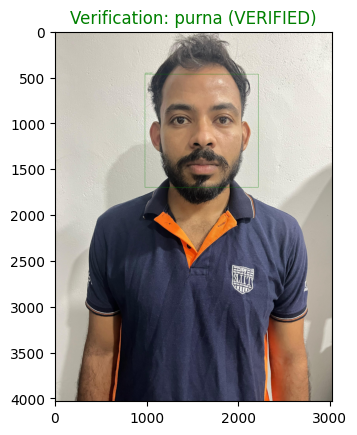

User 'purna' was VERIFIED in purna (6).jpg.


In [16]:
def verify_and_visualize_user(
                                target_username_viz, # Changed param name
                                query_img_path_viz,  # Changed param name
                                faiss_idx_global,
                                db_users_global,
                                verification_threshold=0.50 # Min similarity score to be considered 'verified'
                                ):
    print(f"\nVerifying user '{target_username_viz}' in image '{os.path.basename(query_img_path_viz)}'...")
    
    ret_users, ret_areas, ret_scores = search_face_in_db(
                                                    query_img_path_viz,
                                                    faiss_idx_global,
                                                    db_users_global
                                                    )
    try:
        image = Image.open(query_img_path_viz)
        draw = ImageDraw.Draw(image)
        verified_this_image = False

        for i in range(len(ret_users)):
            x, y, w, h = ret_areas[i]
            user_found = ret_users[i]
            score_found = ret_scores[i]
            
            label = f"{user_found} ({score_found:.2f})"
            color = 'red'

            if user_found == target_username_viz and score_found >= verification_threshold:
                color = 'green'
                verified_this_image = True
            elif user_found != "Unknown" and score_found >= 0.4: # A known user but not target, or target with low score
                color = 'orange'
            
            draw.rectangle([x, y, x+w, y+h], outline=color, width=3)
            try:
                font = ImageFont.truetype("arial.ttf", 15)
            except IOError:
                font = ImageFont.load_default()
            draw.text((x, y-20), label, font=font, fill=color)
        
        plt.imshow(image)
        title_color = 'green' if verified_this_image else 'red'
        plt.title(f"Verification: {target_username_viz} ({'VERIFIED' if verified_this_image else 'NOT VERIFIED'})", color=title_color)
        plt.show()
        
        if verified_this_image:
            print(f"User '{target_username_viz}' was VERIFIED in {os.path.basename(query_img_path_viz)}.")
        else:
            print(f"User '{target_username_viz}' was NOT VERIFIED in {os.path.basename(query_img_path_viz)} (or no strong match).")

    except FileNotFoundError:
        print(f"Error: Image not found at {query_img_path_viz}")
    except Exception as e:
        print(f"Error during visualization for {query_img_path_viz}: {e}")

# Example: Verifying 'purna' in a test image
# This should be run AFTER the global faiss_index is available.
if faiss_index and faiss_index.ntotal > 0:
    print("\n--- Verifying a Specific User in a Test Image ---")
    test_img_verify = 'data/test_images/purna (6).jpg' # Ensure this image exists
    if os.path.exists(test_img_verify):
        verify_and_visualize_user(
                                "purna",
                                test_img_verify,
                                faiss_idx_global=faiss_index,
                                db_users_global=db_user_names
                                )
    else:
        print(f"Test image for verification not found: {test_img_verify}")
else:
    print("Cannot verify user because FAISS index is not available or empty.")

In [17]:
def verify_and_visualize_user_realtime(
                                        target_username_rt, # Changed param name
                                        faiss_idx_global,
                                        db_users_global,
                                        rt_verification_threshold=0.50
                                        ):
    if faiss_idx_global is None or faiss_idx_global.ntotal == 0:
        print("Realtime Error: FAISS index is not available or empty. Cannot start.")
        return

    cap = cv.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Cannot open webcam.")
        return

    temp_image_path_rt = "data/temp_dir/temp_rt.jpg" # Unique name for temp file
    print("Starting real-time verification. Press 'q' in the OpenCV window to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame from webcam.")
            break

        cv.imwrite(temp_image_path_rt, frame) # Save current frame
        
        # Perform search on the saved frame
        rt_ret_users, rt_ret_areas, rt_ret_scores = search_face_in_db(
                                                                temp_image_path_rt,
                                                                faiss_idx_global,
                                                                db_users_global
                                                                )
        
        # Draw results on the original frame
        for i in range(len(rt_ret_users)):
            x, y, w, h = rt_ret_areas[i]
            user_found_rt = rt_ret_users[i]
            score_found_rt = rt_ret_scores[i]
            
            label = f"{user_found_rt} ({score_found_rt:.2f})"
            color = (0, 0, 255) # Red (BGR)

            if user_found_rt == target_username_rt and score_found_rt >= rt_verification_threshold:
                color = (0, 255, 0) # Green (BGR)
            elif user_found_rt != "Unknown": # Known but not target, or target with low score
                 color = (0, 165, 255) # Orange (BGR)

            cv.rectangle(frame, (x, y), (x+w, y+h), color, 2)
            font = cv.FONT_HERSHEY_SIMPLEX
            cv.putText(frame, label, (x, y-10), font, 0.6, color, 2) # Adjusted font size

        cv.imshow('Real-time Verification (Press q to quit)', frame)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()
    if os.path.exists(temp_image_path_rt): # Clean up temp file
        os.remove(temp_image_path_rt)
    print("Stopped real-time verification.")

# Example: Real-time verification for 'purna'
# This should be run AFTER the global faiss_index is available.
# if faiss_index and faiss_index.ntotal > 0:
#     print("\n--- Starting Real-time Verification ---")
#     verify_and_visualize_user_realtime(
#                                     "purna",
#                                     faiss_idx_global=faiss_index,
#                                     db_users_global=db_user_names
#                                     )
# else:
#     print("Cannot start real-time verification because FAISS index is not available or empty.")

print("\n--- End of Notebook ---")


--- End of Notebook ---


In [1]:
# Example: Real-time verification for 'purna'
# This should be run AFTER the global faiss_index is available.
if faiss_index and faiss_index.ntotal > 0:
    print("\n--- Starting Real-time Verification ---")
    verify_and_visualize_user_realtime(
                                    "dilshan",
                                    faiss_idx_global=faiss_index,
                                    db_users_global=db_user_names
                                    )
else:
    print("Cannot start real-time verification because FAISS index is not available or empty.")

NameError: name 'faiss_index' is not defined

In [2]:
models = [
        "VGG-Face", 
        "Facenet", 
        "Facenet512", 
        "OpenFace", 
        "DeepFace", 
        "DeepID", 
        "ArcFace", 
        "Dlib", 
        "SFace",
        "GhostFaceNet",
        ]

In [4]:
def create_dataset(
                data_dir = "data/facedb/*/*.*",
                json_dir = "data/facedb_jsons/{}/{}",
                ):
    for img_path in glob.glob(data_dir):
        person_objs = []
        img_path = img_path.replace("\\", "/")
        person_name = img_path.split("/")[-2]
        file_name = img_path.split("/")[-1]
        face_objs = DeepFace.represent(
                                    img_path = img_path,
                                    model_name = "Facenet512",
                                    enforce_detection = False
                                    )
        if len(face_objs) > 0:
            for i in range(len(face_objs)):
                person_json = {}
                facial_area = face_objs[i]['facial_area']
                x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
                person_json['person_name'] = person_name
                person_json['facial_area'] = facial_area
                person_json['file_name'] = file_name
                person_json['coor'] = (x, y, w, h)
                person_objs.append(person_json)

        if len(person_objs) > 0:
            os.makedirs(json_dir.format(person_name, ""), exist_ok=True)
            json_file = json_dir.format(person_name, file_name.replace(".jpg", ".json"))
            with open(json_file, 'w') as json_file:
                json.dump(person_objs, json_file)

In [ ]:
create_dataset()

### Detection Model

In [5]:
def load_detection_dataset(
                            data_dir = "data/facedb/*/*.*"
                            ):
    X, Y = [], []
    for img_path in glob.glob(data_dir):
        json_path = img_path.replace("\\", "/").replace("facedb", "facedb_jsons").replace(".jpg", ".json")
        if (os.path.exists(json_path)):
            with open(json_path, 'r') as json_file:
                json_data = json.load(json_file)
                person = json_data[0]
                x, y, w, h = person['coor']
                img = cv.imread(img_path)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, (128, 128))

                X.append(img)
                Y.append((x, y, w, h))

    return np.array(X), np.array(Y)

In [6]:
X, Y = load_detection_dataset() 

print("Image Shape: ", X.shape)
print("Label Shape: ", Y.shape)

Image Shape:  (393, 128, 128, 3)
Label Shape:  (393, 4)


In [29]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(4)
                                    ])

model.compile(
                optimizer='adam', 
                loss='mean_squared_error', 
                metrics=['mae']
                )
model.fit(
        X, Y, 
        epochs=200
        )

Epoch 1/200
13/13 [==============================] - 2s 107ms/step - loss: 147685.3906 - mae: 264.6060
Epoch 2/200
13/13 [==============================] - 1s 109ms/step - loss: 70900.0625 - mae: 178.4787
Epoch 3/200
13/13 [==============================] - 1s 103ms/step - loss: 66483.3906 - mae: 170.4852
Epoch 4/200
13/13 [==============================] - 1s 106ms/step - loss: 63886.6445 - mae: 165.7112
Epoch 5/200
13/13 [==============================] - 1s 107ms/step - loss: 60777.0234 - mae: 161.3738
Epoch 6/200
13/13 [==============================] - 1s 105ms/step - loss: 56200.9219 - mae: 153.6610
Epoch 7/200
13/13 [==============================] - 1s 112ms/step - loss: 50917.9688 - mae: 148.2225
Epoch 8/200
13/13 [==============================] - 1s 109ms/step - loss: 50272.3164 - mae: 152.6995
Epoch 9/200
13/13 [==============================] - 1s 112ms/step - loss: 42245.5742 - mae: 141.9893
Epoch 10/200
13/13 [==============================] - 1s 110ms/step - loss: 33646

In [7]:
def visualize_face_detection(img_path):
    face_objs = DeepFace.represent(
                                img_path = img_path,
                                model_name = "Facenet512",
                                enforce_detection = False
                                )
    for i in range(len(face_objs)):
        facial_area = face_objs[i]['facial_area']
        face_confidence = face_objs[i]['face_confidence']
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

        image = Image.open(img_path)
        draw = ImageDraw.Draw(image)
        draw.rectangle([x, y, x+w, y+h], outline='red', width=5)
        font = ImageFont.truetype("arial.ttf", 30)
        draw.text((x-30, y-40), f'Confidence: {face_confidence}', font=font, fill='blue')
        
    plt.imshow(image)


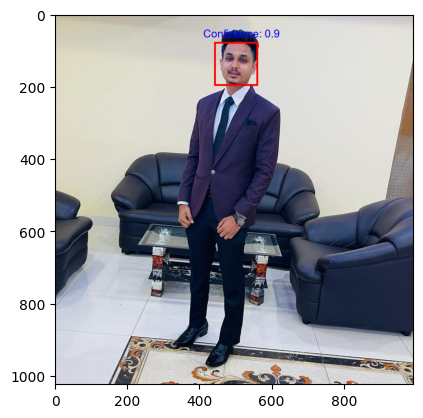

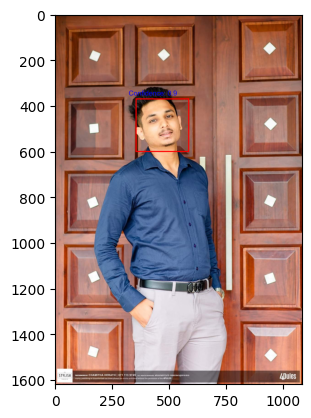

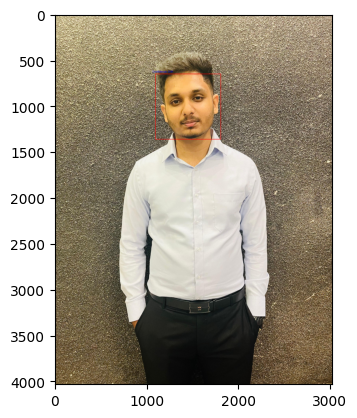

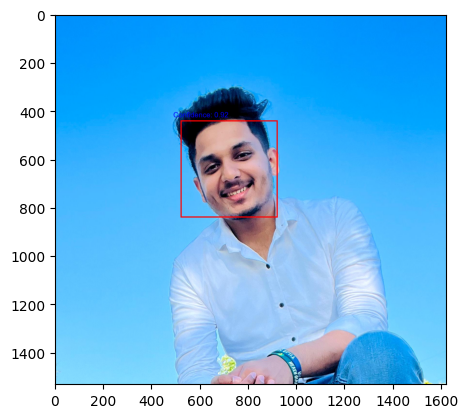

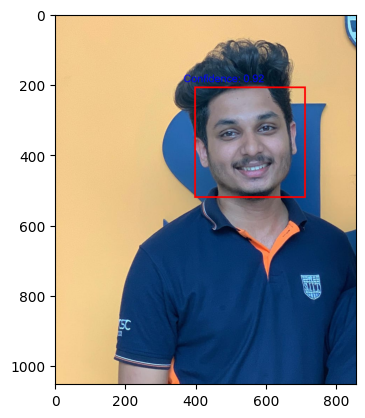

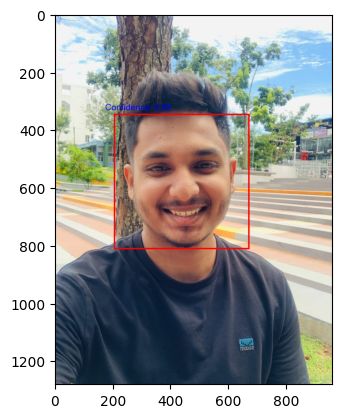

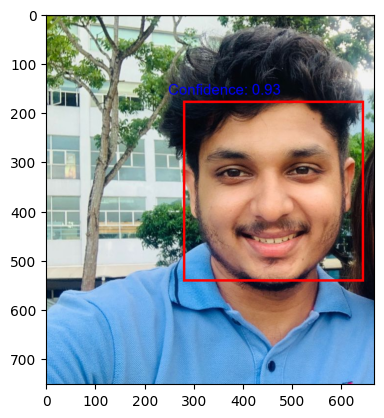

In [ ]:
img_dir = "data/facedb/Mohamed Inthisham"
for img_path in glob.glob(f"{img_dir}/*.*"):
    visualize_face_detection(img_path)
    plt.show()

In [8]:
def extract_face_information_for_db(img_path):
    # face_objs = DeepFace.represent(
    #                                 img_path = img_path, 
    #                                 detector_backend = backends[4],
    #                                 align = alignment_modes[0],
    #                                 enforce_detection = False
    #                                 )
    face_objs = DeepFace.represent(
                                img_path = img_path,
                                model_name = models[2],
                                enforce_detection = False
                                )
    img_path = img_path.replace("\\", "/")
    user_name = img_path.split("/")[-2]

    if len(face_objs) != 1:
        if len(face_objs) == 0:
            Warning(f"No faces detected in the image : {img_path}")
        else:
            Warning(f"Multiple faces detected in the image : {img_path}")
        return None, None, None, None

    else:
        facial_area = face_objs[0]['facial_area']
        embeddings = face_objs[0]['embedding']
        face_confidence = face_objs[0]['face_confidence']
        x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

    return embeddings, face_confidence, (x, y, w, h), user_name

def extract_face_information_for_inference(img_path):
    face_objs = DeepFace.represent(
                                img_path = img_path,
                                model_name = models[2],
                                enforce_detection = False
                                )
    img_path = img_path.replace("\\", "/")

    embeddings = []
    facial_areas = []
    face_confidences = []

    if len(face_objs) == 0:
        Warning(f"No faces detected in the image : {img_path}")
    else:
        for i in range(len(face_objs)):
            embs = face_objs[i]['embedding']
            facial_area = face_objs[i]['facial_area']
            face_confidence = face_objs[i]['face_confidence']
            x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

            embeddings.append(embs)
            facial_areas.append((x, y, w, h))   
            face_confidences.append(face_confidence)

    return embeddings, face_confidences, facial_areas

In [9]:
def build_face_embedding_index(
                                d = 512,
                                face_index_path = 'models/face_index',
                                face_image_dir = 'data/facedb/*/*.jpg',
                                face_details_path = 'models/face_details.npz',
                                ):
    if (not os.path.exists(face_index_path)) or (not os.path.exists(face_details_path)):
        faiss_index = faiss.index_factory(d, "Flat", faiss.METRIC_INNER_PRODUCT)

        embeddings = []
        user_names = []
        facial_areas = []
        face_confidences = []
        
        for idx, img_path in enumerate(glob.glob(face_image_dir)):
            emb, face_confidence, facial_area, user_name = extract_face_information_for_db(img_path)
            if emb is not None:
                embeddings.append(emb)
                user_names.append(user_name)
                facial_areas.append(facial_area)
                face_confidences.append(face_confidence)

            if idx % 10 == 0:
                print(f"Processed {idx}/{len(glob.glob(face_image_dir))} images")

        embeddings = np.asarray(embeddings).astype('float32')
        faiss.normalize_L2(embeddings)
        faiss_index.add(embeddings)
        faiss.write_index(faiss_index, face_index_path)

        np.savez(
                face_details_path, 
                user_names=user_names, 
                facial_areas=facial_areas, 
                face_confidences=face_confidences
                )
        
    else:
        faiss_index = faiss.read_index(face_index_path)
        face_details = np.load(face_details_path)
        user_names = face_details['user_names']
        facial_areas = face_details['facial_areas']
        face_confidences = face_details['face_confidences']

    return faiss_index, user_names, facial_areas, face_confidences

In [7]:
index, user_names, facial_areas, face_confidences = build_face_embedding_index()

Processed 0/393 images
Processed 10/393 images
Processed 20/393 images
Processed 30/393 images
Processed 40/393 images
Processed 50/393 images
Processed 60/393 images
Processed 70/393 images
Processed 80/393 images
Processed 90/393 images
Processed 100/393 images
Processed 110/393 images
Processed 120/393 images
Processed 130/393 images
Processed 140/393 images
Processed 150/393 images
Processed 160/393 images
Processed 170/393 images
Processed 180/393 images
Processed 190/393 images
Processed 200/393 images
Processed 210/393 images
Processed 220/393 images
Processed 230/393 images
Processed 240/393 images
Processed 250/393 images
Processed 260/393 images
Processed 270/393 images
Processed 280/393 images
Processed 290/393 images
Processed 300/393 images
Processed 310/393 images
Processed 320/393 images
Processed 330/393 images
Processed 340/393 images
Processed 350/393 images
Processed 360/393 images
Processed 370/393 images
Processed 380/393 images
Processed 390/393 images


In [10]:
def add_user_to_db(
                    username, 
                    face_index_path = 'models/face_index',
                    face_details_path = 'models/face_details.npz',
                    face_image_dir = 'data/facedb/{}/*.jpg',
                    force_write = False
                    ):
    index, user_names, facial_areas, face_confidences = build_face_embedding_index(
                                                                                    face_index_path = face_index_path,
                                                                                    face_details_path = face_details_path,
                                                                                    )
    if username in user_names:
        if not force_write:
            Warning(f"User {username} already exists in the database")
            return
    
    user_names_to_add = []
    facial_areas_to_add = []
    face_confidences_to_add = []

    for img_path in glob.glob(face_image_dir.format(username)):
        emb, face_confidence, facial_area, user_name = extract_face_information_for_db(img_path)
        if emb is not None:
            embeddings = np.array([emb]).astype('float32')
            faiss.normalize_L2(embeddings)
            index.add(embeddings)
            user_names_to_add.append(user_name)
            facial_areas_to_add.append(facial_area)
            face_confidences_to_add.append(face_confidence)

    faiss.write_index(index, face_index_path)

    if len(user_names_to_add) > 0:
        user_names = np.concatenate([user_names, user_names_to_add])
        facial_areas = np.concatenate([facial_areas, facial_areas_to_add])
        face_confidences = np.concatenate([face_confidences, face_confidences_to_add])

    np.savez(
            face_details_path, 
            user_names=user_names, 
            facial_areas=facial_areas, 
            face_confidences=face_confidences
            )
    
    print(f"User : {username} added to the database")

def search_face_in_db(
                    img_path, 
                    face_index_path = 'models/face_index',
                    face_details_path = 'models/face_details.npz',
                    ):
    index, user_names, _, _ = build_face_embedding_index(
                                                        face_index_path = face_index_path,
                                                        face_details_path = face_details_path,
                                                        )
    embeddings, face_confidences, facial_areas = extract_face_information_for_inference(img_path)

    retrieved_user_names = []
    retrieved_facial_areas = []
    retrieved_face_confidences = []

    if embeddings is not None:
        for idx, emb in enumerate(embeddings):
            if face_confidences[idx] >= 0.8:
                emb = np.array(emb).reshape(1, -1).astype('float32')
                faiss.normalize_L2(emb)
                D, I = index.search(emb, 5)
                I = np.array(I).squeeze()
                D = np.array(D).squeeze()
                user_name_list = [user_names[i] for i in I]
                user_name = max(set(user_name_list), key = user_name_list.count)
                avg_confidence = np.mean([d for i, d in zip(I, D) if user_names[i] == user_name])
                retrieved_face_confidences.append(np.round(avg_confidence, 3))
                retrieved_facial_areas.append(facial_areas[idx])
                retrieved_user_names.append(user_name)

    return retrieved_user_names, retrieved_facial_areas, retrieved_face_confidences

def verify_and_visualize_user(  
                                username,
                                img_path,
                                ):
    retrieved_user_names, retrieved_facial_areas, retrieved_face_confidences = search_face_in_db(img_path)

    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)

    for i in range(len(retrieved_user_names)):
        x, y, w, h = retrieved_facial_areas[i]
        face_area = w * h
        if (face_area >= 20000):
            if (retrieved_user_names[i] == username) and (retrieved_face_confidences[i] >= 0.5):
                draw.rectangle([x, y, x+w, y+h], outline='green', width=5)
                font = ImageFont.truetype("arial.ttf", 30)
                draw.text((x-30, y-70), f'User: {retrieved_user_names[i]}', font=font, fill='green')
            else:
                draw.rectangle([x, y, x+w, y+h], outline='red', width=5)
                font = ImageFont.truetype("arial.ttf", 30)

    plt.imshow(image)
    plt.show()

def verify_and_visualize_user_realtime(username):
    cap = cv.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        cv.imwrite("data/temp_dir/temp.jpg", frame)
        
        retrieved_user_names, retrieved_facial_areas, retrieved_face_confidences = search_face_in_db("data/temp_dir/temp.jpg")
        for i in range(len(retrieved_user_names)):
            x, y, w, h = retrieved_facial_areas[i]
            face_area = w * h
            if (face_area >= 20000):
                if (retrieved_user_names[i] == username) and (retrieved_face_confidences[i] >= 0.5):
                    cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    font = cv.FONT_HERSHEY_SIMPLEX
                    cv.putText(frame, f'User: {retrieved_user_names[i]}', (x-30, y-40), font, 1, (0, 255, 0), 2)
                else:
                    cv.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

        cv.imshow('frame', frame)

        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

In [18]:
add_user_to_db(
                'Mohamed Inthisham', 
                # force_write=True
                )

In [19]:
img_dir = "data/facedb/Mohamed Inthisham"
for img_path in glob.glob(f"{img_dir}/*.*"):
    retrieved_user_names, retrieved_facial_areas, retrieved_face_confidences = search_face_in_db(img_path)

    print(f"Retrieve User Names : {retrieved_user_names}")
    print(f"Retrieve Face Confidences : {retrieved_face_confidences}")
    print(f"Retrieve Facial Areas : {retrieved_facial_areas}")

Retrieve User Names : ['Alexandra Daddario', 'Mohamed Inthisham']
Retrieve Face Confidences : [0.709, 0.859]
Retrieve Facial Areas : [(378, 433, 54, 54), (440, 77, 121, 121)]
Retrieve User Names : ['Mohamed Inthisham']
Retrieve Face Confidences : [0.872]
Retrieve Facial Areas : [(352, 369, 234, 234)]
Retrieve User Names : ['Mohamed Inthisham']
Retrieve Face Confidences : [0.858]
Retrieve Facial Areas : [(1090, 651, 715, 715)]
Retrieve User Names : ['Mohamed Inthisham']
Retrieve Face Confidences : [0.84]
Retrieve Facial Areas : [(520, 440, 402, 402)]
Retrieve User Names : ['Mohamed Inthisham']
Retrieve Face Confidences : [0.882]
Retrieve Facial Areas : [(395, 206, 316, 316)]
Retrieve User Names : ['Mohamed Inthisham']
Retrieve Face Confidences : [0.802]
Retrieve Facial Areas : [(203, 345, 468, 468)]
Retrieve User Names : ['Mohamed Inthisham']
Retrieve Face Confidences : [0.87]
Retrieve Facial Areas : [(278, 176, 367, 367)]


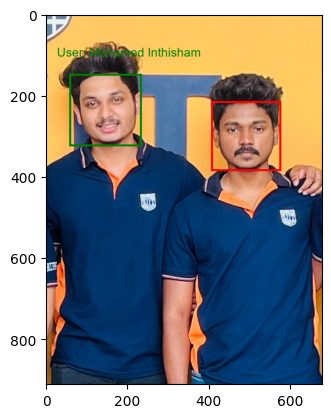

In [13]:
#verify_and_visualize_user("Mohamed Inthisham", 'data/facedb/Mohamed Inthisham/IMG-20241103-WA0052.jpg')
verify_and_visualize_user("Mohamed Inthisham", 'data/test_images/IMG-20241103-WA0061.jpg')

In [11]:
verify_and_visualize_user_realtime("Mohamed Inthisham")

KeyboardInterrupt: 